In [1]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)
from skimage.segmentation import quickshift, slic

Using TensorFlow backend.


Notebook run using keras: 2.2.4


In [2]:
!pip install pillow

## Using Inception

Here we create a standard InceptionV3 pretrained model and use it on images by first preprocessing them with the preprocessing tools

In [3]:
inet_model = inc_net.InceptionV3()

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
import PIL.Image

In [5]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

## Let's see the top 5 prediction for some image

('n02112137', 'chow', 0.14622861)
('n02109961', 'Eskimo_dog', 0.048644744)
('n02099712', 'Labrador_retriever', 0.03815895)
('n02105412', 'kelpie', 0.03699346)
('n02123045', 'tabby', 0.036803436)


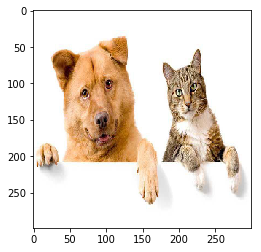

In [6]:
from PIL import Image
images = transform_img_fn(['./photo_2019-03-19_22-24-29.jpg'])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds, top=5)[0]:
    print(x)

## Explanation

Now let's get an explanation

In [7]:
%load_ext autoreload
%autoreload 2
import os,sys
import lime_sk
import image_processing2

In [8]:
sorted_labels = np.argsort(-preds[0])
sorted_labels[:5]

array([260, 248, 208, 227, 281])

hide_color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels. Here, we set it to 0 (in the representation used by inception model, 0 means gray)

In [9]:
label = 281

In [15]:
%%time
explainer = image_processing2.ImageExplainer(label=label, kernel_width=1, random_state=42)
explanation = explainer.explain_prediction(images[0], inet_model.predict, hide_color=0, num_samples=1000, num_features=20)

CPU times: user 15min 33s, sys: 8.85 s, total: 15min 41s
Wall time: 2min 20s


In [16]:
for x in explanation.local_explanation[0]:
    print(x)

(29, 0.05924488655084386)
(42, -0.05315774076436186)
(19, 0.04666619662400432)
(36, 0.04114547759469975)
(13, 0.03714858468590017)
(49, 0.02720058125359473)
(35, -0.026693332616264682)
(28, -0.02425194832167585)
(27, -0.0221006413797578)
(50, -0.01937371205155131)
(34, -0.019190465578400564)
(24, -0.017696131334658163)
(53, 0.017078440772967378)
(17, -0.015781781585046874)
(23, -0.015666973178100597)
(80, -0.009726096379436609)
(30, -0.00901070737404791)
(61, -0.00875572363313781)
(67, -0.007981345441314994)
(20, -0.006989229037690051)


In [21]:
explanation.score

## Now let's see the explanation for the top class ( golden retriever)

We can see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

In [17]:
from skimage.segmentation import mark_boundaries

In [18]:
def get_image_and_mask_test(explanation, positive_only=True, hide_rest=False,
                       num_features=5, min_weight=0.):
    """
    Constructs image and mask to visualize explanation

    Args:
        positive_only: if True, only take superpixels that contribute to
            the prediction of the label. Otherwise, use the top
            num_features superpixels, which can be positive or negative
            towards the label
        hide_rest: if True, make the non-explanation part of the return
            image gray
        num_features: number of superpixels to include in explanation
        min_weight: min_weight for the superpixel
    Returns:
        (image, mask), where image is a 3d numpy array and mask is a 2d
        numpy array
    """

    segments = explanation.segments
    image = explanation.image
    explanation = explanation.local_explanation[0]  # explanation of the particular label
    mask = np.zeros(segments.shape, segments.dtype)

    # show or hide original image
    if hide_rest:
        bg = np.zeros(image.shape)
    else:
        bg = image.copy()
    
    # look for maximum positive and minimum negative weigth
    weights = []
    for ind, w in explanation:
        weights.append(w)
    weights = np.array(weights)
    
    max_pos_w = np.max(weights)
    min_neg_w = np.max(-weights)
        
    # show or hide negative contributions
    if positive_only:
        # list of superpixel indices
        positive_weights_index = [x[0] for x in explanation
                                  if x[1] > 0 and x[1] > min_weight][:num_features]
        for ind in positive_weights_index:
            # activate image parts which correspond to the positively
            # weighted superpixels
            bg[segments == ind] = image[segments == ind].copy()
        mask[segments == ind] = 1
        return bg, mask
    else:
        for ind, w in explanation[:num_features]:
            if np.abs(w) < min_weight:
                continue # skip superpixels with small weights
            # channels
            # red = img[:, :, 0]
            # green = img[:, :, 1]
            # blue = img[:, :, 2]
            if w < 0:
                c = 0 
#                 norm = min_neg_w
            else:
                c = 1
#                 norm = max_pos_w
            norm = max_pos_w
            mask[segments == ind] = 1 if w < 0 else 2
            bg[segments == ind] = 0.
            bg[segments == ind, c] = abs(w)/norm
            
        return bg, mask

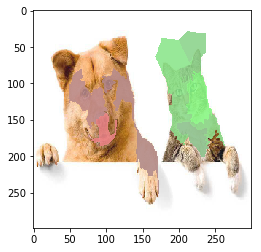

In [19]:
temp, mask = get_image_and_mask_test(explanation, positive_only=False, num_features=10, hide_rest=False)
plt.imshow((images[0]/2 + 0.5), alpha=0.6)
plt.imshow((temp/2 + 0.5), alpha=0.8)

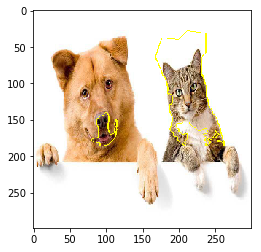

In [15]:
temp, mask = explanation.get_image_and_mask(positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

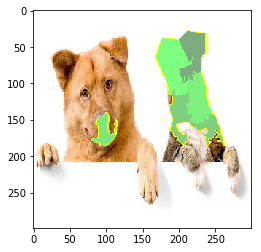

In [16]:
temp, mask = explanation.get_image_and_mask(positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or the pros and cons that have weight at least 0.1

In [ ]:
temp, mask = explanation.get_image_and_mask(positive_only=False, num_features=1000, hide_rest=False, min_weight=0.05)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))